# Exploitation du code et des données

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import defaultdict

%matplotlib inline

## 1. Visualisation des données

In [2]:
df_map = pd.DataFrame.from_csv('data/20160630_CDS_Id_Mapping.csv', sep=';', index_col='CDS_Id')
df_cds = pd.DataFrame.from_csv('data/20160630_ITRAXX5Y.csv', sep=';', index_col='Date')

In [3]:
print 'data/20160630_CDS_Id_Mapping.csv :\n'
print df_map.head(3)
print ''
print 'data/20160630_ITRAXX5Y.csv :\n'
print df_cds.head(3)

data/20160630_CDS_Id_Mapping.csv :

                Name
CDS_Id              
261            Total
238     Saint-Gobain
570         Barclays

data/20160630_ITRAXX5Y.csv :

              Name  CDS_Id   Y05
Date                            
2003-07-23  ITRAXX       2  68.0
2003-07-24  ITRAXX       2  63.0
2003-07-25  ITRAXX       2  63.0


In [4]:
dc_map = defaultdict(list)
for _id, _name in df_map.itertuples():
    dc_map[_name].append(_id)

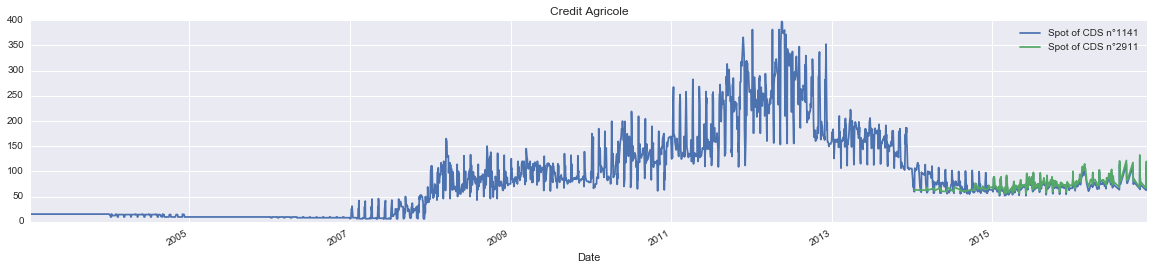

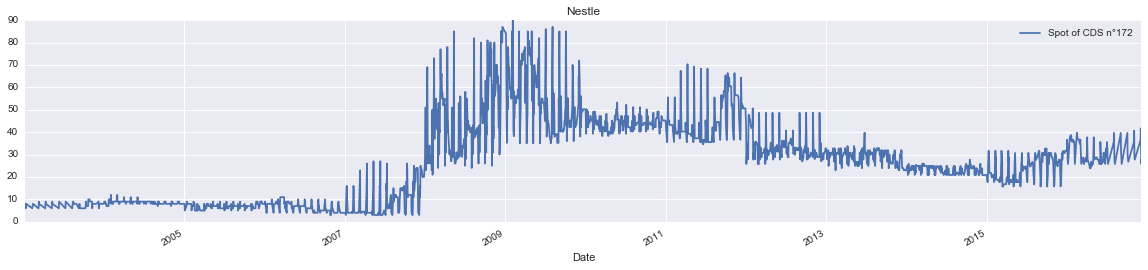

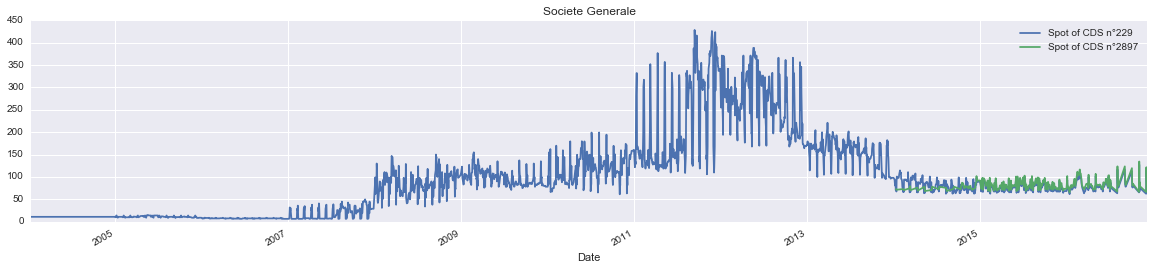

In [5]:
_names = ['Credit Agricole', 'Nestle', 'Societe Generale']
for _name in _names:
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
    for _i, _id in enumerate(dc_map[_name]):
        df_cds.loc[df_cds.loc[:, 'CDS_Id'] == _id, 'Y05'].plot(
            title = _name
            , ax = axes
            , label = 'Spot of CDS n°' + str(_id))
    plt.legend()
    plt.show()

On remarque un bouleversement des valeurs des CDS au cours de l'année 2007... quel hasard !

## 2. Analyse des rendements des CDS

L'article sur lequel porte notre projet traite des distributions des rendements des actifs. Avant d'appliquer les méthodes décrites dans ce dernier, nous devons transformer nos données de sorte à n'avoir à travailler qu'avec des rendements d'actifs (ici des CDS) sur lesquels on construira à terme notre porte-feuille d'actions optimisé au sens de Malevergne et Sornette.

In [6]:
dc_returns = {}
for _id in df_map.index.values:
    dc_returns[_id] = (
            df_cds.loc[df_cds.loc[:, 'CDS_Id'] == _id, 'Y05'].diff()    # absolute return...
            / df_cds.loc[df_cds.loc[:, 'CDS_Id'] == _id, 'Y05'].shift() # ... got normalized
        )

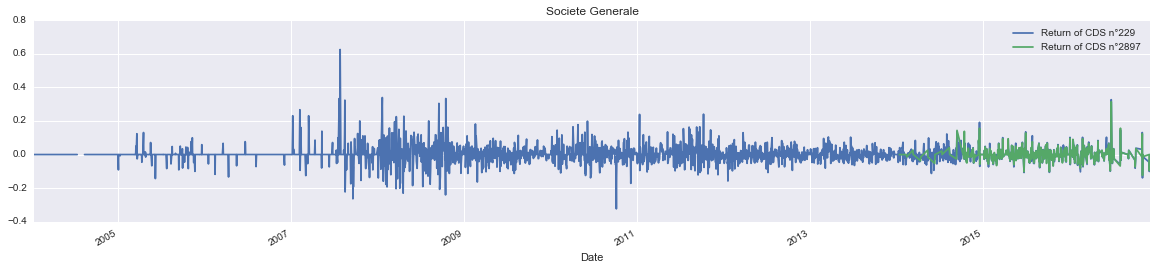

In [7]:
_names = ['Societe Generale']
for _name in _names:
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
    for _id in dc_map[_name]:
        dc_returns[_id].plot(
            title = _name
            , ax = axes
            , label = 'Return of CDS n°' + str(_id))
    plt.legend()
    plt.show()

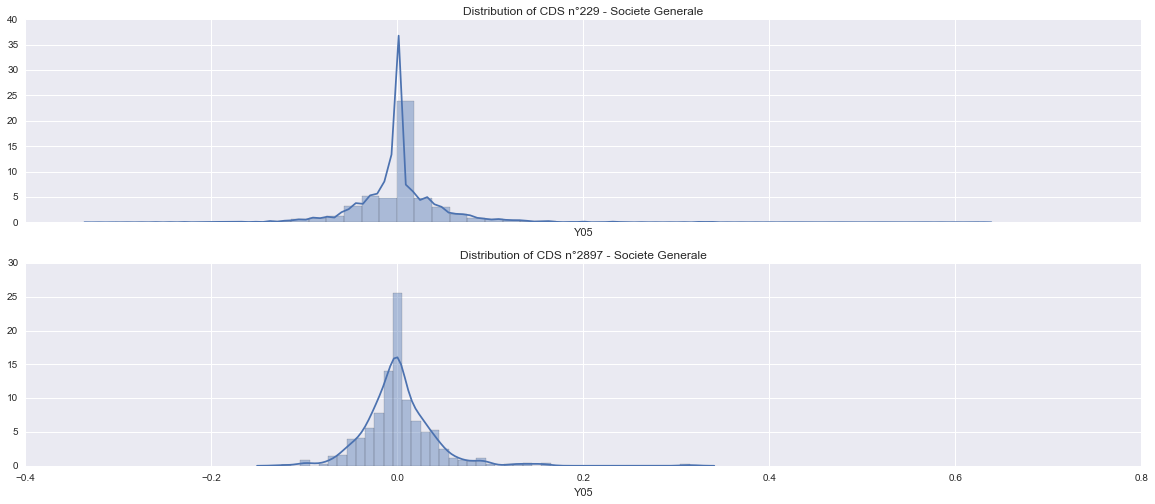

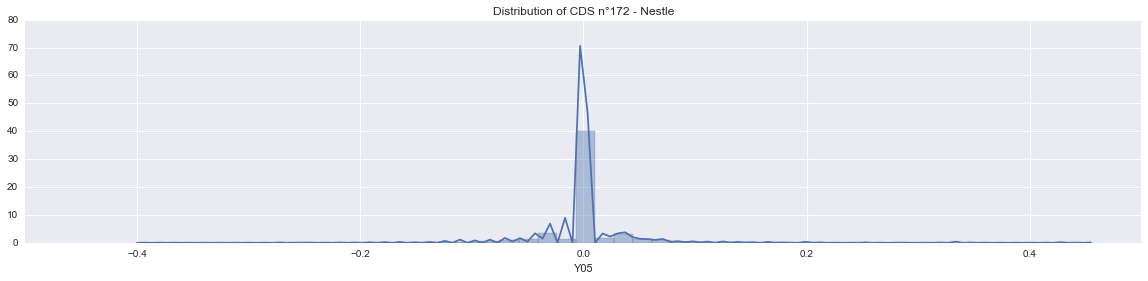

In [8]:
_names = ['Societe Generale', 'Nestle']
for _name in _names:
    _n = len(dc_map[_name])
    fig, axes = plt.subplots(nrows=_n, ncols=1, figsize=(20, 4*_n), sharex=True)
    plt.subplots_adjust(top=0.9)
    for _i, _id in enumerate(dc_map[_name]):
        try:
            ax = axes[_i]
        except TypeError:
            ax = axes
        df = dc_returns[_id]
        ax.set_title(u"Distribution of CDS n°{} - {}".format(_id, _name))
        sns.distplot(df[df == df]
                     , ax = ax
                    )
    plt.show()

La distribution des rendements n'est pas du tout gaussienne.